In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

In [2]:
sns.set(style="whitegrid", context="talk")
pd.set_option("display.max_columns", None)

------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Bootstrap – Zufallsstichproben verstehen

Bevor wir viele Bäume mit Bagging trainieren, schauen wir uns an,
was beim **Bootstrap-Sampling** eigentlich passiert.

**Ziel dieser Einheit**
- Zufallsstichproben *mit Zurücklegen* simulieren.
- Verstehen, warum manche Werte mehrfach vorkommen und andere gar nicht.
- Sehen, wie Bootstrap-Stichproben helfen, die *Unsicherheit* einer Statistik (z. B. Mittelwert) abzuschätzen.

Alles ohne Machine Learning – nur Statistik & Zufall!


In [3]:
# "Population": einfache Zahlen 1 bis 10
population = np.arange(1, 11)
print("Population:", population)

# Eine Stichprobe von 10 Werten *mit Zurücklegen*
sample = np.random.choice(population, size=10, replace=True)
print("Bootstrap-Sample:", sample)

Population: [ 1  2  3  4  5  6  7  8  9 10]
Bootstrap-Sample: [5 5 9 6 2 4 1 8 9 9]


Jeder Wert 1–10 kann mehrfach vorkommen, weil wir **mit Zurücklegen** ziehen.
Ohne Zurücklegen hätten wir jeden Wert genau einmal.

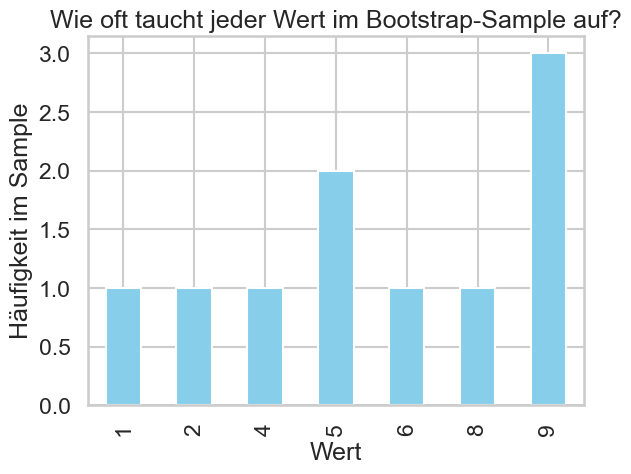

In [4]:
counts = pd.Series(sample).value_counts().sort_index()
counts.plot(kind="bar", color="skyblue")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit im Sample")
plt.title("Wie oft taucht jeder Wert im Bootstrap-Sample auf?")
plt.show()

## Aufgabe
- Welche Zahlen fehlen komplett?
- Welche kommen doppelt oder dreifach vor?
- Warum ist das wichtig für Machine Learning später?


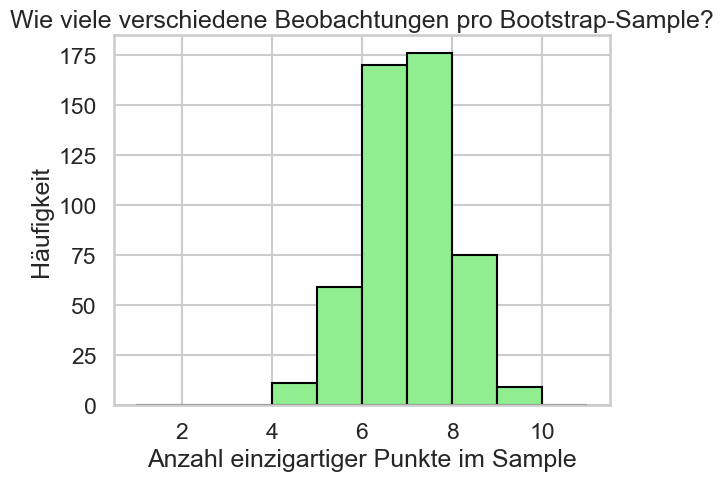

Durchschnittlicher Anteil einzigartiger Punkte: 0.6544


In [5]:
n = 10
reps = 500
unique_counts = []

for _ in range(reps):
    idx = np.random.choice(np.arange(n), size=n, replace=True)
    unique_counts.append(len(np.unique(idx)))

plt.hist(unique_counts, bins=range(1, n+2), color="lightgreen", edgecolor="black")
plt.xlabel("Anzahl einzigartiger Punkte im Sample")
plt.ylabel("Häufigkeit")
plt.title("Wie viele verschiedene Beobachtungen pro Bootstrap-Sample?")
plt.show()

print("Durchschnittlicher Anteil einzigartiger Punkte:",
      np.mean(unique_counts)/n)

Ergebnis: Im Mittel sind etwa **63 %** der Punkte einzigartig,
die restlichen **37 %** werden *nicht* gezogen.

Das ist die berühmte **Bootstrap-Zahl 0.632**.


In [6]:
# Population mit leichter Schiefe (z. B. Einkommen)
population = np.random.exponential(scale=1000, size=5000)
true_mean = population.mean()

# Wir ziehen eine Stichprobe von 100 Personen
sample = np.random.choice(population, size=100, replace=False)
sample_mean = sample.mean()

print(f"Wahrer Mittelwert (Population): {true_mean:.2f}")
print(f"Stichproben-Mittelwert: {sample_mean:.2f}")

Wahrer Mittelwert (Population): 1018.83
Stichproben-Mittelwert: 968.73


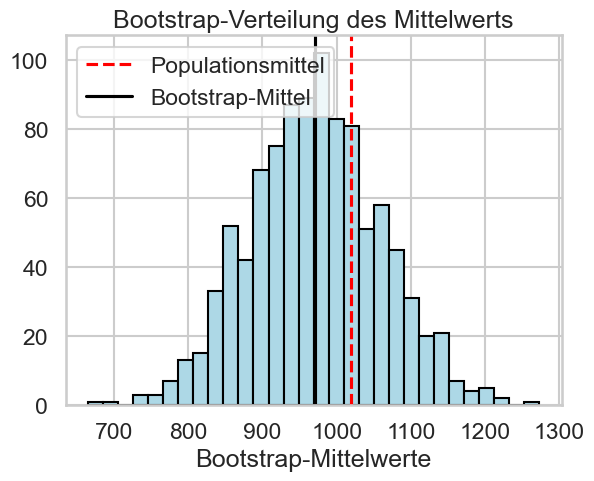

In [7]:
n_boot = 1000
boot_means = []

for i in range(n_boot):
    boot = np.random.choice(sample, size=len(sample), replace=True)
    boot_means.append(np.mean(boot))

plt.hist(boot_means, bins=30, color="lightblue", edgecolor="black")
plt.axvline(true_mean, color="red", linestyle="--", label="Populationsmittel")
plt.axvline(np.mean(boot_means), color="black", linestyle="-", label="Bootstrap-Mittel")
plt.legend()
plt.xlabel("Bootstrap-Mittelwerte")
plt.title("Bootstrap-Verteilung des Mittelwerts")
plt.show()

- Jeder Balken = Mittelwert einer Bootstrap-Stichprobe.
- Die Streuung zeigt, wie unsicher unser geschätzter Mittelwert ist.
- Der Mittelwert der Verteilung ≈ dem ursprünglichen Stichprobenmittel.

💬 Frage:
Wie würdest du ein **95 %-Konfidenzintervall** aus diesen Bootstrap-Werten schätzen?


In [8]:
ci_lower, ci_upper = np.percentile(boot_means, [2.5, 97.5])
print(f"95%-Bootstrap-Konfidenzintervall: [{ci_lower:.2f}, {ci_upper:.2f}]")

95%-Bootstrap-Konfidenzintervall: [804.40, 1141.97]


Das Intervall sagt: Wenn wir denselben Stichprobenprozess viele Male wiederholen würden,
läge der wahre Mittelwert in etwa 95 % der Fälle in diesem Bereich.

Bootstrap ermöglicht also Unsicherheitsabschätzung **ohne Formeln** –
nur durch Resampling.


## Variation
1. Wiederhole den Bootstrap mit einer kleineren Stichprobe (n = 30).  
   → Wie wird das Intervall?
2. Probiere statt des Mittelwerts den **Median**.
3. Optional: Mach denselben Versuch mit `replace=False`  
   → Was fällt dir auf?


# Fazit – Bootstrap verstehen

- Beim Ziehen *mit Zurücklegen* wird jedes Sample leicht anders.
- Etwa **63 %** der Daten erscheinen mindestens einmal → der Rest bleibt **OOB**.
- Durch viele Bootstrap-Samples lässt sich **Streuung** oder **Unsicherheit** empirisch abschätzen.
- Genau dieses Prinzip nutzt **Bagging**, um viele leicht unterschiedliche Modelle zu trainieren.

Brauchen wir hier: **Bagging mit Decision Trees**


------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Decision Trees


In [9]:
# Titanic-Datensatz aus seaborn laden (geht offline oder online)
titanic = sns.load_dataset("titanic")

# Zeige die ersten 5 Zeilen
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [10]:
# Größe des Datensatzes
print("Form:", titanic.shape)

# Welche Spalten gibt es?
print("\nSpalten:")
print(titanic.columns.tolist())

# Kurze Beschreibung numerischer Spalten
titanic.describe()

Form: (891, 15)

Spalten:
['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# Unser Ziel (was wir vorhersagen wollen): 'survived'
titanic["survived"].value_counts(normalize=True)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## Zielvariable „survived“
- `1` bedeutet: Person hat überlebt  
- `0` bedeutet: Person ist gestorben  

In [12]:
# Wähle einige einfache Spalten aus (ohne Leaks)
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]

# Nur Zeilen ohne fehlende Werte verwenden
df = titanic[features + ["survived"]].dropna()

# Kategorische Variablen in Zahlen umwandeln
df = pd.get_dummies(df, columns=["sex", "embarked"], drop_first=True)

# X = Eingabedaten, y = Ziel
X = df.drop("survived", axis=1)
y = df["survived"]

print("Form von X:", X.shape)
X.head()

Form von X: (712, 8)


,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=41, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (534, 8) Test: (178, 8)


In [14]:
help(DummyClassifier)

Help on class DummyClassifier in module sklearn.dummy:

class DummyClassifier(sklearn.base.MultiOutputMixin, sklearn.base.ClassifierMixin, sklearn.base.BaseEstimator)
 |  DummyClassifier(*, strategy='prior', random_state=None, constant=None)
 |  
 |  DummyClassifier makes predictions that ignore the input features.
 |  
 |  This classifier serves as a simple baseline to compare against other more
 |  complex classifiers.
 |  
 |  The specific behavior of the baseline is selected with the `strategy`
 |  parameter.
 |  
 |  All strategies make predictions that ignore the input feature values passed
 |  as the `X` argument to `fit` and `predict`. The predictions, however,
 |  typically depend on values observed in the `y` parameter passed to `fit`.
 |  
 |  Note that the "stratified" and "uniform" strategies lead to
 |  non-deterministic predictions that can be rendered deterministic by setting
 |  the `random_state` parameter if needed. The other strategies are naturally
 |  deterministi

In [15]:
# Baseline: Modell, das einfach rät oder immer den häufigsten Wert nimmt
dummy_majority = DummyClassifier(strategy="most_frequent")
dummy_majority.fit(X_train, y_train)
y_pred_dummy = dummy_majority.predict(X_test)

acc = accuracy_score(y_test, y_pred_dummy)
print("Baseline Accuracy (always majority):", acc)

Baseline Accuracy (always majority): 0.5955056179775281


In [16]:
y_pred_dummy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [17]:
y_test

232    0
315    1
98     1
102    0
514    0
      ..
505    0
720    1
833    0
816    0
416    1
Name: survived, Length: 178, dtype: int64

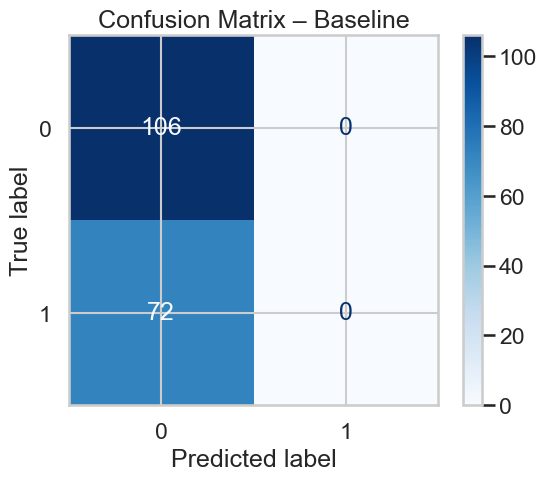

In [18]:
cm_d = confusion_matrix(y_test, y_pred_dummy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_d)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Baseline")
plt.show()

In [19]:
dummy_random = DummyClassifier(strategy="stratified", random_state=42)
dummy_random.fit(X_train, y_train)
y_pred_random = dummy_random.predict(X_test)
acc_rand = accuracy_score(y_test, y_pred_random)
print("Random guess Accuracy:", acc_rand)

Random guess Accuracy: 0.5168539325842697


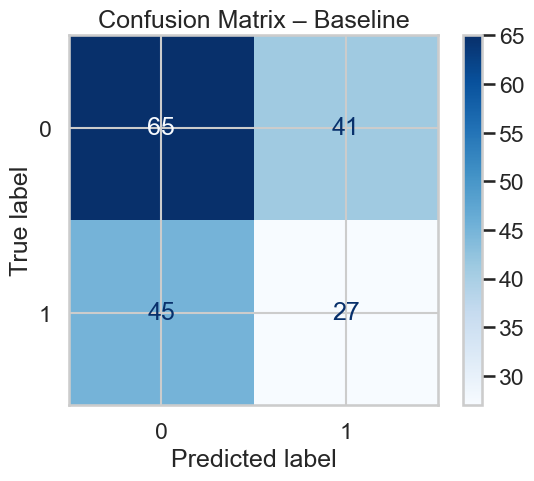

In [20]:
cm_r = confusion_matrix(y_test, y_pred_random)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_r)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Baseline")
plt.show()

In [21]:
baseline_results = pd.DataFrame({
    "model": ["Always majority", "Random"],
    "accuracy": [acc, acc_rand]
})
baseline_results

,model,accuracy
0,Always majority,0.595506
1,Random,0.516854


## Interpretation
- Diese Werte sind unsere **Baseline**: So gut ist „reines Raten“.
- Jedes spätere Modell (z. B. Decision Tree) muss **besser als das** sein.

## Aufgaben
1. Erstelle ein Dummy-Modell mit `strategy="uniform"`.  
   → Was ist der Unterschied zu „stratified“?
2. Teste, ob sich die Accuracy stark verändert, wenn du `random_state` änderst.  
   → Warum oder warum nicht?
3. Diskutiere mit deinem Nachbarn:  
   - Warum brauchen wir solche Baselines überhaupt?


------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Unser einfacher Decision Tree

**Ziel dieses Abschnitts**
- Einen Decision Tree trainieren und evaluieren.
- Verstehen, wie Tiefe und Blattgröße das Modellverhalten beeinflussen.
- Erste Visualisierungen interpretieren.

**Wichtige Begriffe**
- **Knoten / Split:** teilt die Daten nach einer Regel (z. B. „age < 30“).
- **Blatt:** Endpunkt des Baums; enthält eine Vorhersage.
- **Tiefe:** Anzahl der Entscheidungsebenen – je größer, desto komplexer.


In [22]:
# Ein einfacher Decision Tree ohne Begrenzungen
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

Test Accuracy: 0.775


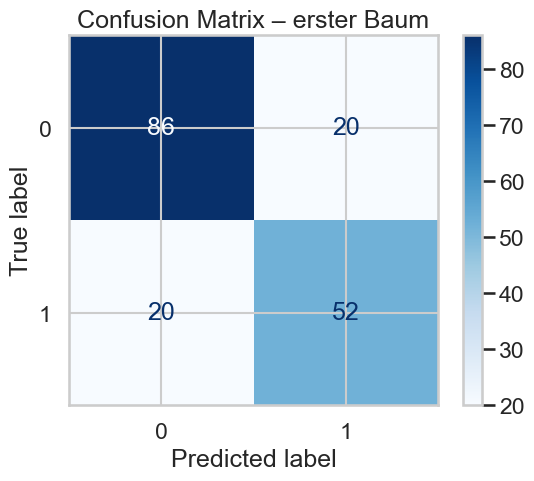

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – erster Baum")
plt.show()

## Erste Bewertung
- Wie viele Überlebende (1) werden korrekt erkannt?
- Wie viele Nicht-Überlebende (0) werden falsch klassifiziert?
- Achtung: Eine hohe Accuracy kann täuschen, wenn die Klassen unausgewogen sind!

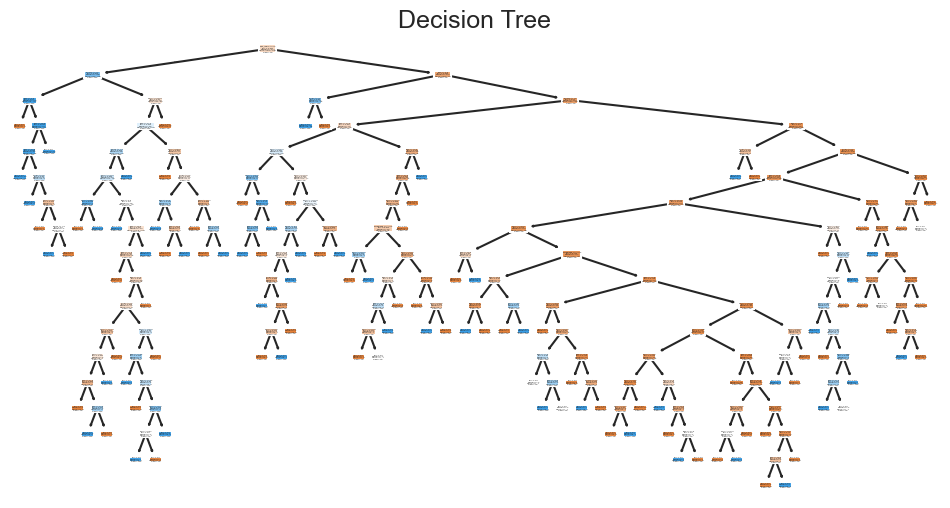

In [24]:
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns, class_names=["no", "yes"],
          filled=True)
plt.title("Decision Tree")
plt.show()


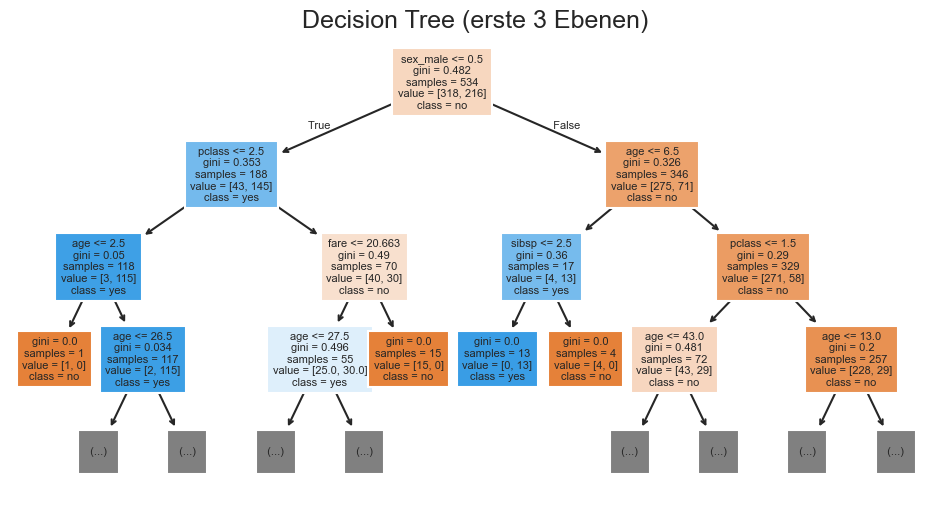

In [25]:
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns, class_names=["no", "yes"],
          filled=True, max_depth=3, fontsize=8)
plt.title("Decision Tree (erste 3 Ebenen)")
plt.show()

Der Baum liest sich **von oben nach unten**:
- In jedem Knoten steht die Frage („Feature < Schwelle?“).
- Rechts/links teilt die Datenmenge.
- In den Blättern sieht man, welcher Anteil überlebt hat.

Was fällt dir auf?
- Welche Variablen nutzt der Baum besonders oft?
- Sind das plausible Entscheidungen?


## Aufgabe
1. Probier `criterion="entropy"` statt `"gini"`.  
   → Ändert sich etwas? Warum oder warum nicht?
2. Finde ein Setting, bei dem Train- und Test-Accuracy ungefähr gleich sind.
3. Überlege: Wie könnte man „Overfitting“ noch erkennen außer über den Test-Fehler?


# Early Stopping und Pruning

In diesem Abschnitt lernst du:
- **Early Stopping:** den Baum beim Wachsen begrenzen (z. B. Tiefe, Blätter).
- **Pruning:** den Baum *nachträglich* beschneiden, um Rauschen zu entfernen.
- Warum das hilft, **Overfitting** zu vermeiden.

**Ziel:** Den Punkt finden, an dem der Baum *gerade komplex genug* ist.

In [26]:
depths = [1, 2, 3, 4, 5, 6, 8, 10, 15, None]
train_acc, test_acc = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

df_depth = pd.DataFrame({"max_depth": depths,
                         "train_acc": train_acc,
                         "test_acc": test_acc})
df_depth

,max_depth,train_acc,test_acc
0,1.0,0.786517,0.758427
1,2.0,0.822097,0.741573
2,3.0,0.840824,0.775281
3,4.0,0.857678,0.758427
4,5.0,0.868914,0.769663
5,6.0,0.880150,0.752809
6,8.0,0.925094,0.769663
7,10.0,0.945693,0.769663
8,15.0,0.981273,0.764045
9,NaN,0.988764,0.775281


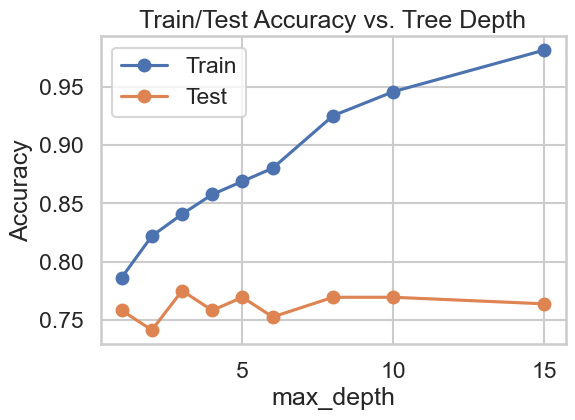

In [27]:
plt.figure(figsize=(6,4))
plt.plot(df_depth["max_depth"], df_depth["train_acc"], label="Train", marker="o")
plt.plot(df_depth["max_depth"], df_depth["test_acc"], label="Test", marker="o")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs. Tree Depth")
plt.legend()
plt.show()

## Beobachtung
- Warum steigt die Trainingsgenauigkeit immer weiter?
- Warum fällt die Testgenauigkeit irgendwann ab?
- Wie nennt man dieses Verhalten?

Notiere in einem Satz, was *Overfitting* bedeutet.

In [28]:
leaf_sizes = [1, 2, 5, 10, 20, 50]
train_acc, test_acc = [], []

for leaf in leaf_sizes:
    clf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

df_leaf = pd.DataFrame({"min_samples_leaf": leaf_sizes,
                        "train_acc": train_acc,
                        "test_acc": test_acc})
df_leaf

,min_samples_leaf,train_acc,test_acc
0,1,0.988764,0.775281
1,2,0.945693,0.775281
2,5,0.882022,0.752809
3,10,0.861423,0.764045
4,20,0.835206,0.735955
5,50,0.805243,0.747191


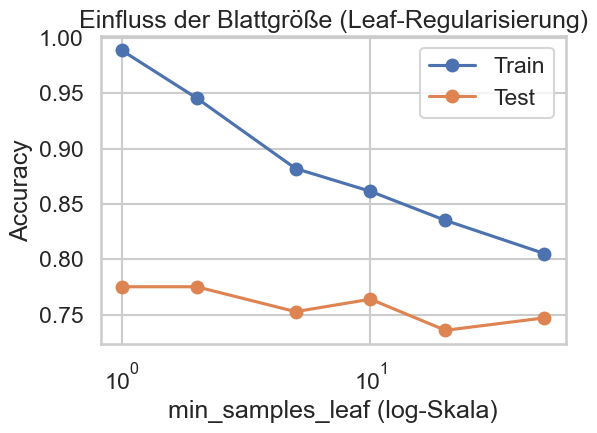

In [29]:
plt.figure(figsize=(6,4))
plt.plot(df_leaf["min_samples_leaf"], df_leaf["train_acc"], label="Train", marker="o")
plt.plot(df_leaf["min_samples_leaf"], df_leaf["test_acc"], label="Test", marker="o")
plt.xscale("log")
plt.xlabel("min_samples_leaf (log-Skala)")
plt.ylabel("Accuracy")
plt.title("Einfluss der Blattgröße (Leaf-Regularisierung)")
plt.legend()
plt.show()

- Kleine Blätter = viele, sehr feine Regeln → Gefahr von **Overfitting**.
- Größere Blätter = glattere Regeln, weniger Varianz → stabiler, evtl. etwas Bias.

Welche Kombination aus `max_depth` und `min_samples_leaf` scheint vernünftig?

In [30]:
# kleine Grid-Suche für Gefühl
depths = [3, 4, 5, 6, 8, 10]
leaves = [1, 2, 5, 10, 20]
results = []

for d in depths:
    for l in leaves:
        clf = DecisionTreeClassifier(max_depth=d,
                                     min_samples_leaf=l,
                                     random_state=42)
        clf.fit(X_train, y_train)
        results.append({
            "max_depth": d,
            "min_leaf": l,
            "train_acc": clf.score(X_train, y_train),
            "test_acc": clf.score(X_test, y_test)
        })

df_grid = pd.DataFrame(results)
df_grid.pivot(index="max_depth", columns="min_leaf", values="test_acc")

min_leaf,1,2,5,10,20
max_depth,,,,,
3,0.775281,0.775281,0.780899,0.764045,0.747191
4,0.758427,0.758427,0.764045,0.747191,0.735955
5,0.769663,0.769663,0.775281,0.758427,0.735955
6,0.752809,0.747191,0.735955,0.764045,0.735955
8,0.769663,0.758427,0.752809,0.764045,0.735955
10,0.769663,0.769663,0.752809,0.764045,0.735955


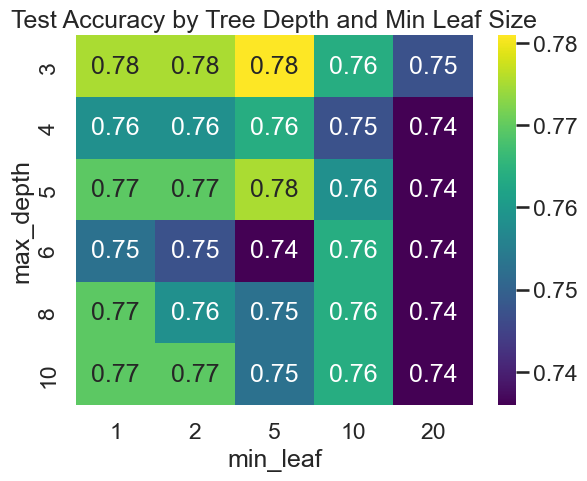

In [31]:
pivot = df_grid.pivot(index="max_depth", columns="min_leaf", values="test_acc")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("Test Accuracy by Tree Depth and Min Leaf Size")
plt.show()

In [32]:
# Erzeuge zuerst einen großen Baum
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [33]:
# Pfad der Cost-Complexity-Pruning-Parameter abrufen
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [34]:
# mehrere pruned Bäume trainieren
train_scores, test_scores = [], []
for ccp_alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_pruned.fit(X_train, y_train)
    train_scores.append(clf_pruned.score(X_train, y_train))
    test_scores.append(clf_pruned.score(X_test, y_test))

df_prune = pd.DataFrame({
    "ccp_alpha": ccp_alphas,
    "train_acc": train_scores,
    "test_acc": test_scores
})
df_prune.head()

,ccp_alpha,train_acc,test_acc
0,0.000000,0.988764,0.775281
1,0.000375,0.988764,0.775281
2,0.000468,0.988764,0.769663
3,0.000624,0.988764,0.769663
4,0.000897,0.988764,0.769663


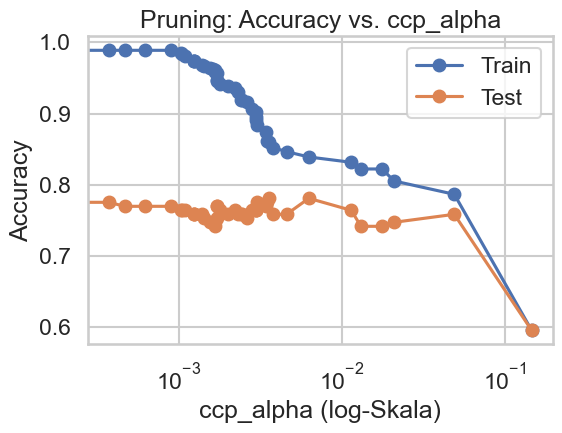

In [35]:
plt.figure(figsize=(6,4))
plt.plot(df_prune["ccp_alpha"], df_prune["train_acc"], marker="o", label="Train")
plt.plot(df_prune["ccp_alpha"], df_prune["test_acc"], marker="o", label="Test")
plt.xscale("log")
plt.xlabel("ccp_alpha (log-Skala)")
plt.ylabel("Accuracy")
plt.title("Pruning: Accuracy vs. ccp_alpha")
plt.legend()
plt.show()

## Was passiert hier?
- Kleine `alpha` → fast kein Schnitt → komplexer Baum.
- Große `alpha` → starker Schnitt → kleiner, einfacher Baum.

Der **sweet spot** liegt dort, wo der Test-Fehler minimal ist,
aber der Baum noch nicht völlig simplifiziert ist.

Überleg: Wie unterscheidet sich Pruning von Early Stopping?


In [36]:
best_alpha = df_prune.loc[df_prune["test_acc"].idxmax(), "ccp_alpha"]
print("Bestes alpha:", best_alpha)

clf_best = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_best.fit(X_train, y_train)

Bestes alpha: 0.003587703549615553


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


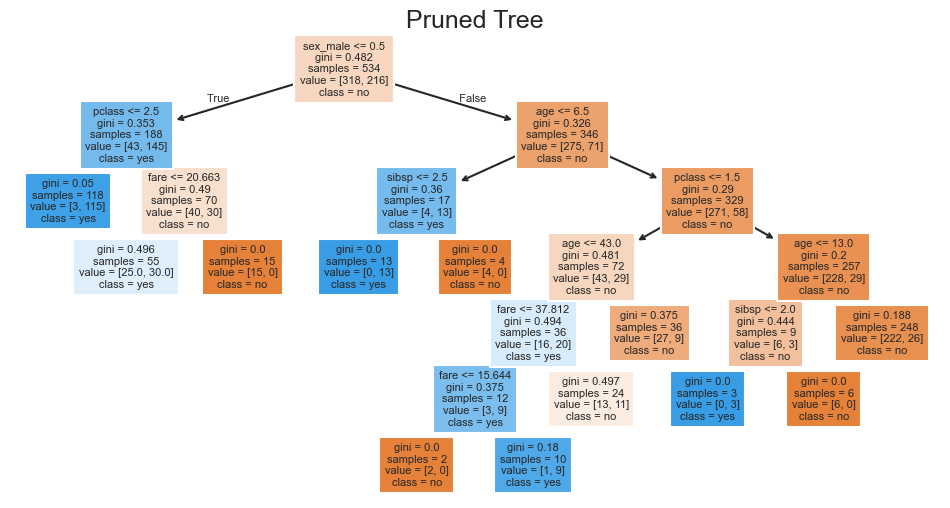

In [37]:
plt.figure(figsize=(12,6))
plot_tree(clf_best, feature_names=X.columns, class_names=["no", "yes"],
          filled=True, fontsize=8)
plt.title("Pruned Tree")
plt.show()

## Aufgabe
1. Vergleiche `max_depth`-Limitierung mit Pruning:
   - Was verändert sich an der Struktur?
2. Versuch, `min_samples_leaf` UND `ccp_alpha` gleichzeitig zu kombinieren.
   → Wird der Baum stabiler?
3. Wie würdest du *systematisch* den besten Punkt finden?
   (Tipp: Cross-Validation)

## Fazit
- **Early Stopping** begrenzt den Baum beim Wachsen.
- **Pruning** schneidet nachträglich unwichtige Zweige ab.
- Beide Methoden helfen, **Varianz zu verringern** und **Overfitting** zu vermeiden.
- Es gibt kein „richtig“ – nur eine gute Balance aus *Bias* und *Varianz*.

------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Bagging („Bootstrap Aggregation“)

**Was ist Bagging?**
- Idee: Statt *einem* Decision Tree trainieren wir **viele Bäume auf leicht unterschiedlichen Daten**.
- Jeder Baum sieht eine **zufällige Stichprobe (mit Zurücklegen)** aus dem Trainingsset.
- Am Ende **mitteln** (oder „stimmen“) alle Bäume gemeinsam ab.

**Warum?**
- Einzelne Bäume sind „nervös“ – sie reagieren stark auf kleine Datenänderungen.
- Viele unabhängige Bäume → Varianz sinkt → stabilere Vorhersage.


In [38]:
# Wir ziehen Bootstrap-Samples aus dem Trainingsset
n = len(X_train)
idx = np.arange(n)
bootstrap_idx = np.random.choice(idx, size=n, replace=True)

print("Anzahl gezogener Punkte:", len(bootstrap_idx))
print("Einzigartige Punkte im Sample:", len(np.unique(bootstrap_idx)))

Anzahl gezogener Punkte: 534
Einzigartige Punkte im Sample: 348


In [39]:
def oob_fraction(n=1000, reps=2000):
    fracs = []
    for _ in range(reps):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        fracs.append(len(np.unique(idx)) / n)
    return np.mean(fracs)

for n in [50, 200, 1000, 5000]:
    print(f"n={n:4d} → Anteil einzigartiger Punkte ≈ {oob_fraction(n):.3f}")

n=  50 → Anteil einzigartiger Punkte ≈ 0.637
n= 200 → Anteil einzigartiger Punkte ≈ 0.633
n=1000 → Anteil einzigartiger Punkte ≈ 0.632
n=5000 → Anteil einzigartiger Punkte ≈ 0.632


In [40]:
n_estimators = 10
models = []
preds = []

for i in range(n_estimators):
    # Bootstrap Sample
    boot_idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    Xb, yb = X_train.iloc[boot_idx], y_train.iloc[boot_idx]

    # Baum trainieren (unpruned für Varianz)
    model = DecisionTreeClassifier(random_state=42 + i)
    model.fit(Xb, yb)
    models.append(model)

    # Vorhersage auf Testdaten
    preds.append(model.predict(X_test))

# Mehrheit: jede Spalte = Baum, Zeile = Beobachtung
preds = np.array(preds)
y_pred_bag = (preds.mean(axis=0) > 0.5).astype(int)

acc_bag = accuracy_score(y_test, y_pred_bag)
print(f"Bagging (10 Bäume) Accuracy: {acc_bag:.3f}")

Bagging (10 Bäume) Accuracy: 0.770


In [41]:
single_scores = [accuracy_score(y_test, preds[i]) for i in range(n_estimators)]
df_compare = pd.DataFrame({
    "Tree": range(1, n_estimators+1),
    "Single_Accuracy": single_scores
})
df_compare.loc["Mean"] = ["–", np.mean(single_scores)]
display(df_compare)

print("Ensemble Accuracy:", acc_bag)

,Tree,Single_Accuracy
0,1,0.747191
1,2,0.752809
2,3,0.719101
3,4,0.691011
4,5,0.696629
5,6,0.786517
6,7,0.730337
7,8,0.730337
8,9,0.735955
9,10,0.702247


Ensemble Accuracy: 0.7696629213483146


## Vergleiche
- Wie stark schwanken die Einzel-Bäume?
- Ist das Ensemble stabiler?  
- Warum kann der Mittelwert „ruhiger“ sein als jeder einzelne Baum?

Erklär: Warum hilft **Mittelung** gegen Varianz?

In [42]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    oob_score=True,
    random_state=42
)

bag.fit(X_train, y_train)

print("OOB-Score:", bag.oob_score_)
print("Test-Accuracy:", bag.score(X_test, y_test))

OOB-Score: 0.8033707865168539
Test-Accuracy: 0.7584269662921348


**OOB-Score**
- nutzt die 37 % der Punkte, die ein Baum *nicht* gesehen hat.
- ähnlich wie Cross-Validation, aber automatisch im Training enthalten.
- spart Rechenzeit und vermeidet Datenverlust.

In [43]:
n_values = [1, 5, 10, 20, 50, 100, 200]
oob_scores, test_scores = [], []

for n_est in n_values:
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=n_est,
        oob_score=True,
        random_state=43
    )
    bag.fit(X_train, y_train)
    oob_scores.append(bag.oob_score_)
    test_scores.append(bag.score(X_test, y_test))

df_b = pd.DataFrame({"n_estimators": n_values,
                     "OOB": oob_scores, "Test": test_scores})
df_b

C:\Users\hubersi\.conda\envs\aml25\Lib\site-packages\sklearn\ensemble\_bagging.py:917: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\hubersi\.conda\envs\aml25\Lib\site-packages\sklearn\ensemble\_bagging.py:923: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\hubersi\.conda\envs\aml25\Lib\site-packages\sklearn\ensemble\_bagging.py:917: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\hubersi\.conda\envs\aml25\Lib\site-packages\sklearn\ensemble\_bagging.py:923: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\hubersi\.conda\envs\aml25\Lib\site-packages\sklearn\ensemble\_bagging.py:917: UserWarning: 

,n_estimators,OOB,Test
0,1,0.653558,0.764045
1,5,0.779026,0.747191
2,10,0.794007,0.769663
3,20,0.801498,0.786517
4,50,0.790262,0.775281
5,100,0.792135,0.786517
6,200,0.805243,0.764045


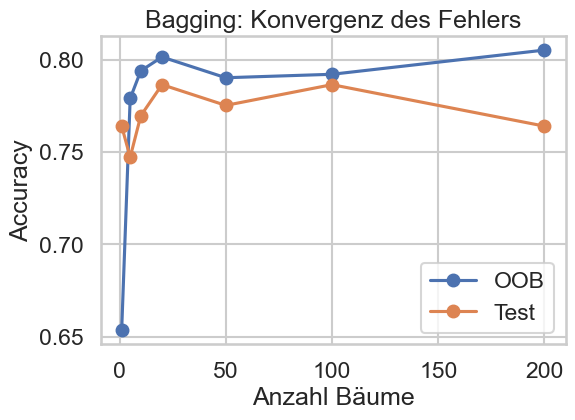

In [44]:
plt.figure(figsize=(6,4))
plt.plot(df_b["n_estimators"], df_b["OOB"], label="OOB", marker="o")
plt.plot(df_b["n_estimators"], df_b["Test"], label="Test", marker="o")
plt.xlabel("Anzahl Bäume")
plt.ylabel("Accuracy")
plt.title("Bagging: Konvergenz des Fehlers")
plt.legend()
plt.show()

- Warum steigt der OOB-Score anfangs schnell und flacht dann ab?
- Wann lohnt es sich **nicht mehr**, neue Bäume hinzuzufügen?

In [45]:
reps = 10
scores = []
for r in range(reps):
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=50,
        random_state=42 + r
    )
    bag.fit(X_train, y_train)
    scores.append(bag.score(X_test, y_test))

print("Varianz über Wiederholungen:", np.std(scores).round(4))
print("Durchschnittlicher Test-Score:", np.mean(scores).round(4))

Varianz über Wiederholungen: 0.01
Durchschnittlicher Test-Score: 0.7685


- Vergleiche: Wie stabil ist Bagging im Vergleich zu einem einzelnen Baum?
- Warum sinkt die Streuung der Ergebnisse mit steigender Baumanzahl?

## Aufgabe
1. Ändere den `estimator`:
   - z. B. `DecisionTreeClassifier(max_depth=3)`  
     → Wie ändert sich der OOB-Score?
2. Probiere `max_samples=0.8` (zieht nur 80 % der Trainingsdaten pro Baum).  
   → Wird der OOB-Score besser oder schlechter?
3. Diskutiere: Wann wäre Bagging *nicht* hilfreich?


## Fazit

- Durch **Bootstrap-Sampling** erhält jeder Baum leicht andere Daten.
- Mittelung der Vorhersagen reduziert **Varianz**.
- Der **OOB-Score** ist ein nützliches, eingebautes Test-Instrument.
- Mehr Bäume → stabiler, aber mit abnehmendem Ertragszuwachs.

**Nächste Woche: Random Forest**  
→ Wir lernen, zusätzlich noch **Feature-Zufall** einzubauen,  
damit die Bäume wirklich unabhängig werden.

------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Lasso – Weniger ist manchmal mehr

**Ziel dieses Abschnitts**
- Verstehen, was **Regularisierung** bedeutet.
- Den Unterschied zwischen **Lasso (L1)** und **Ridge (L2)** kennenlernen.
- Sehen, wie Lasso *unnötige Features auf 0 setzt* (Feature-Selektion).
- Lasso praktisch mit Python ausprobieren.

**Motivation**
→ Modelle sollen nicht nur gut passen, sondern auch *einfach* und *robust* sein.


In [46]:
# Erzeuge Datensatz mit 10 Features, aber nur 3 wirklich relevant
X, y, coef = make_regression(
    n_samples=200,
    n_features=10,
    n_informative=3,
    noise=15,
    coef=True,
    random_state=42
)

X = pd.DataFrame(X, columns=[f"x{i}" for i in range(1, 11)])
print("Echte Koeffizienten (Ground Truth):")
pd.Series(coef, index=X.columns)

Echte Koeffizienten (Ground Truth):


x1      0.000000
x2      0.000000
x3      0.000000
x4      0.000000
x5      0.000000
x6     34.882053
x7      6.600984
x8     40.710649
x9      0.000000
x10     0.000000
dtype: float64

Test-MSE (ohne Regularisierung): 195.41


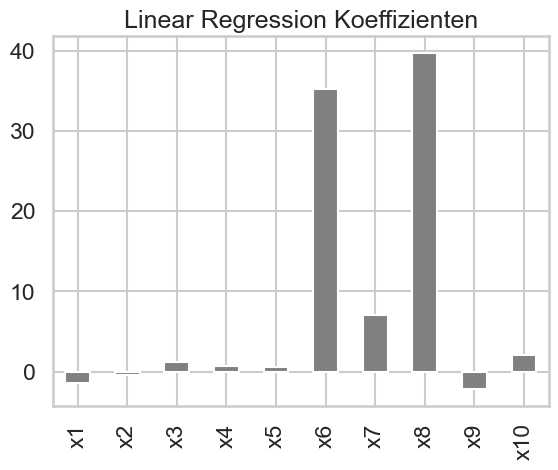

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test-MSE (ohne Regularisierung):", round(mse, 2))

coef_linreg = pd.Series(linreg.coef_, index=X.columns)
coef_linreg.plot(kind="bar", color="gray", title="Linear Regression Koeffizienten")
plt.show()

Hier haben wir ein „freies“ Modell:  
- Keine Einschränkung der Koeffizienten.  
- Passt perfekt auf Trainingsdaten, kann aber auf neuen Daten stark schwanken.

💬 Beobachtung:
- Haben alle Features relevante Gewichte?  
- Oder scheint einiges reines Rauschen zu sein?


- Kleine `alpha` → fast keine Strafe → alle Features aktiv.  
- Große `alpha` → starke Strafe → unwichtige Features werden **auf 0 gesetzt**.

Das ist der Kern des Lasso:  
Es „schrumpft“ Koeffizienten auf 0 → **Feature-Selektion durch Regularisierung**.


In [48]:
mse_values = []

for a in alphas:
    lasso = Lasso(alpha=a, random_state=42, max_iter=5000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    mse_values.append(mean_squared_error(y_test, y_pred))

plt.plot(alphas, mse_values, marker="o")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Test-MSE")
plt.title("Einfluss der Regularisierung auf den Fehler")
plt.show()

NameError: name 'alphas' is not defined

## Beobachtung
- Bei zu kleinem `alpha`: Overfitting → hoher Testfehler.
- Bei zu großem `alpha`: Unterfitting → Modell zu starr.
- Dazwischen: ein „sweet spot“.

👉 Lasso reguliert die *Komplexität* wie `max_depth` beim Baum.


In [ ]:
best_alpha = alphas[np.argmin(mse_values)]
lasso_best = Lasso(alpha=best_alpha, random_state=42, max_iter=5000)
lasso_best.fit(X_train, y_train)

coef_lasso = pd.Series(lasso_best.coef_, index=X.columns)
coef_lasso.plot(kind="bar", color="teal", title=f"Lasso (alpha={best_alpha:.3f}) – Nicht-Null-Koeffizienten")
plt.show()

print("Anzahl nicht-null Koeffizienten:", np.sum(coef_lasso != 0))

- Lasso hat nur einige Features behalten → einfacheres Modell.
- Vergleiche mit den „echten“ relevanten Variablen (aus der Simulation oben).

💬 Frage:
Warum ist ein Modell mit **wenigen Features** oft besser interpretierbar und stabiler?


## Aufgabe
1. Erzeuge einen Datensatz mit **hoher Korrelation** zwischen Features (z. B. 2 identische Spalten).
   → Wie verhält sich Lasso dann?
2. Probiere `alpha=0.01`, `1`, `10` – notiere, wie viele Koeffizienten verschwinden.
3. Was passiert, wenn du statt Lasso `Ridge` (L2) verwendest?
   → Unterscheidung: Ridge **schrumpft**, Lasso **setzt auf 0**.


## Fazit – Lasso verstehen

- Lasso = **L1-Regularisierung** → bestraft die Summe der Beträge der Koeffizienten.
- Effekt: Unwichtige Features werden **eliminiert** (Koeffizient = 0).
- Vorteil: einfachere, robustere Modelle, bessere Interpretierbarkeit.
- Nachteil: kann bei stark korrelierten Features zufällig „eins davon“ wählen.

Nächster Schritt (optional):  
Lasso als **Feature-Filter vor einem Decision Tree oder Random Forest** einsetzen.


------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------

# Lasso + Decision Tree – Feature-Selektion trifft Baum

**Idee:**  
Lasso kann helfen, aus vielen möglichen Features nur die wichtigsten auszuwählen.  
Danach kann ein Decision Tree (oder später Random Forest) auf diesen ausgewählten Spalten trainieren.

**Warum das tun?**
- Weniger Rauschen → stabilere Splits.  
- Weniger Dimensionen → besser interpretierbar.  
- Schnellere Modelle.


In [ ]:
# Wir nehmen wieder Titanic aus Block A
X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Logistic Regression mit L1-Strafe (für Klassifikation)
lasso_selector = LogisticRegression(
    penalty="l1", solver="liblinear", C=0.05, random_state=42
)
lasso_selector.fit(X_train_scaled, y_train)

# Feature-Gewichte ansehen
coef = pd.Series(lasso_selector.coef_[0], index=X.columns)
coef.sort_values(ascending=False)

In [ ]:
selected = X.columns[coef != 0]
print("Ausgewählte Features durch Lasso:", list(selected))
print("Anzahl gewählter Features:", len(selected))

In [ ]:
# 1️) Decision Tree mit allen Features
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)
acc_full = tree_full.score(X_test, y_test)

# 2) Decision Tree nur mit Lasso-Features
tree_lasso = DecisionTreeClassifier(random_state=42)
tree_lasso.fit(X_train[selected], y_train)
acc_lasso = tree_lasso.score(X_test[selected], y_test)

print(f"Accuracy mit allen Features: {acc_full:.3f}")
print(f"Accuracy mit Lasso-Features: {acc_lasso:.3f}")

- Ändert sich die Test-Accuracy stark?  
- Ist der Baum kleiner / übersichtlicher geworden?

Oft bleibt die Genauigkeit ähnlich,  
aber das Modell wird stabiler und einfacher zu interpretieren.


In [ ]:
plt.figure(figsize=(12,6))
plot_tree(tree_lasso, feature_names=selected, class_names=["no", "yes"],
          filled=True, max_depth=3, fontsize=8)
plt.title("Decision Tree nach Lasso-Feature-Selektion (erste 3 Ebenen)")
plt.show()

In [ ]:
def tree_info(tree):
    return {
        "nodes": tree.tree_.node_count,
        "depth": tree.tree_.max_depth
    }

info = pd.DataFrame([
    {"model": "Full Tree", **tree_info(tree_full)},
    {"model": "Lasso Filtered Tree", **tree_info(tree_lasso)}
])
info

- Wie unterscheiden sich **Tiefe** und **Anzahl der Knoten**?
- Warum kann ein einfacherer Baum genauso gut oder sogar besser generalisieren?


##  Aufgabe
1. Ändere den Regularisierungsparameter `C` der Logistic Regression (z. B. 0.1, 1, 10).  
   → Wie viele Features bleiben übrig? Wie ändert sich die Accuracy?
2. Nutze stattdessen `penalty="l2"` (Ridge).  
   → Wie unterscheiden sich die Ergebnisse?
3. Füge ein künstliches, zufälliges Feature hinzu (`np.random.randn`)  
   → Erkennt Lasso, dass es nutzlos ist?


## Fazit – Lasso + Decision Tree

- Lasso kann als **Feature-Filter** vor einem Baum genutzt werden.
- Es hilft, irrelevante Spalten zu eliminieren → weniger Rauschen, stabilere Splits.
- Der Baum bleibt meist ähnlich genau, aber wird **einfacher und interpretierbarer**.

Nächste Woche:
Wir nutzen das gleiche Prinzip in einem **Random Forest**  
und vergleichen Feature-Selektion, Gini-Importance & Permutation Importance.
